# Review Correlation Analysis

## create fewshot dataset from amazon review data

In [1]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from transformers import DataCollatorWithPadding
from transformers import AutoTokenizer
from datasets import load_dataset
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np
import evaluate
import os
import json

2024-07-15 14:06:19.741610: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 14:06:19.741752: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 14:06:19.742849: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-15 14:06:19.751109: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-15 14:06:22.080972: W tensorflow/compiler/tf2

In [4]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm.notebook import tqdm
from transformers import pipeline
import torch
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [6]:
# load the tsv data
df = pd.read_csv('./amazon_reviews_multilingual_US_v1_00.tsv', sep='\t', on_bad_lines="skip")
df = df.query('star_rating != 3.0')
df = df.reset_index().rename(columns = {'index': 'Id'})
print(len(df))

6366340


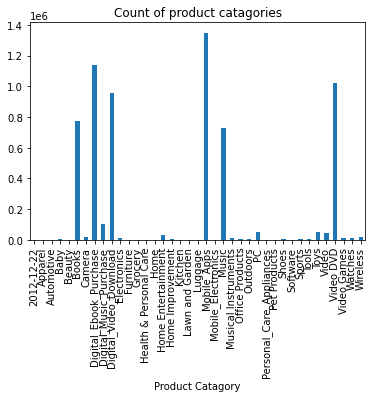

In [4]:
# visualize data distribution
ax = df['product_category'].value_counts().sort_index().plot(kind='bar', title='Count of product catagories')
ax.set_xlabel('Product Catagory')
plt.show()

In [5]:
# find unique product category
products = df['product_category'].unique()
products

array(['Books', 'Music', 'Video', 'Video DVD', 'Toys', 'Tools',
       'Office Products', 'Video Games', 'Software',
       'Digital_Music_Purchase', 'Electronics', 'Digital_Ebook_Purchase',
       'Digital_Video_Download', 'Home Entertainment', 'Kitchen',
       'Camera', 'Outdoors', 'Musical Instruments', 'Sports', 'Watches',
       'PC', 'Home', 'Wireless', 'Beauty', 'Baby', 'Home Improvement',
       'Apparel', 'Shoes', 'Lawn and Garden', 'Mobile_Electronics',
       'Health & Personal Care', 'Luggage', 'Personal_Care_Appliances',
       'Automotive', 'Grocery', 'Mobile_Apps', 'Furniture', '2012-12-22',
       'Pet Products'], dtype=object)

In [9]:
## select 11 products categories 

id2label = {0: "Books", 1: "Music", 2: "Video", 3:"Toys", 4: "Tools", 5: "Office Products", 
            6: "Electronics", 7: "Kitchen", 8: "Sports", 9: "Shoes",
           10: "Health & Personal Care"}

label2id = {"Books": 0, "Music": 1, "Video":2, "Toys": 3, "Tools": 4, "Office Products": 5,
            "Electronics": 6, "Kitchen": 7, "Sports": 8, "Shoes": 9,
           "Health & Personal Care": 10}


In [8]:
# create json file to store data
if not os.path.exists("./amazon_prod_review_cls_train.json") or not os.path.exists("./amazon_prod_review_cls_test.json"):
   data = {'train':[], 'test':[]}
   min_length = 80
   for label in label2id.keys():
       df_i = df.query(f"product_category == '{label}'")
       mask = df_i['review_body'].str.len() > min_length
       df_i = df_i[mask].sample(200)
       df_i = df_i[['Id', 'review_body']].rename(columns = {'review_body': 'text'})
       df_i['label'] = label2id[label]
       df_i_train = df_i[:150]
       df_i_test = df_i[150:]
       data['train'].extend(json.loads(df_i_train.to_json(orient="records")))
       data['test'].extend(json.loads(df_i_test.to_json(orient="records")))
   with open("./amazon_prod_review_cls_train.json", "w") as f:
       json.dump(data['train'], f)
   with open("./amazon_prod_review_cls_test.json", "w") as f:
       json.dump(data['test'], f)
   print('==> train data size:', len(data['train']))
   print('==> test data size:', len(data['test']))

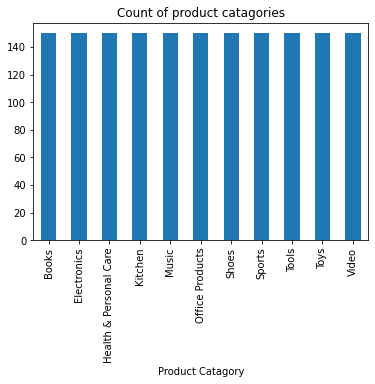

In [8]:
# visualize data distribution
ax = pd.DataFrame(data['train'])['label'].map(id2label).value_counts().sort_index().plot(kind='bar', title='Count of product catagories')
ax.set_xlabel('Product Catagory')
plt.show()

In [6]:
data_files = {
    "train": "amazon_prod_review_cls_train.json",  # train json path
    "test": "amazon_prod_review_cls_test.json"     # test json path
}
dataset = load_dataset("json", data_files=data_files)

train_dataset = dataset['train']
test_dataset = dataset['test']

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [7]:
train_dataset

Dataset({
    features: ['Id', 'text', 'label'],
    num_rows: 1650
})

## SLMs correlation analysis

### define SLM correlation analysis eval pipeline

In [58]:
import torch
import torch.nn.functional as F
def pipeline_corr_eval_slm(tokenizer, model, data, id2label, use_gpu=False):
    
    res_dict = {}
    correct = [0 for _ in range(11)]
    correct_top2 = [0 for _ in range(11)]
    correct_top3 = [0 for _ in range(11)]
    total = [0 for _ in range(11)]
    preds = []
    labels = []
    incorrect = []
    fp = [0 for _ in range(11)]
    fn = [0 for _ in range(11)]

    start_time = time.time()
    if use_gpu:
        model = model.to('cuda:0')
    else:
        model = model.to('cpu')
    with torch.no_grad():
        for i, row in tqdm(enumerate(data), total=len(data)):
          text = row['text']
          label = int(row['label'])
          token = tokenizer(text, truncation=True, add_special_tokens=True, max_length=512, padding=True, return_tensors="pt")
          if use_gpu:
            token = token.to('cuda:0')
          logits = model(**token).logits
          pred_cls = logits.argmax(axis=1).cpu().item()
          pred_cls_top3 = logits.argsort(axis=1)[0][-3:].cpu().numpy()
          # pred_logits = logits.sort(axis=1)[0][-3:].cpu().numpy()
          
          probs = F.softmax(logits, dim=1).sort(axis=1).values[0][-3:].cpu().numpy().sum() 
          
          res_dict[i] = {'Id': row['Id'], 'pred': id2label[pred_cls]}
          total[label] += 1
          preds.append(pred_cls)
          labels.append(label)
          if pred_cls == label:
              correct[int(label)] += 1
              correct_top2[int(label)] += 1
              correct_top3[int(label)] += 1
          elif label == pred_cls_top3[1]:
              correct_top2[int(label)] += 1
              correct_top3[int(label)] += 1
          elif label == pred_cls_top3[0]:
              correct_top3[int(label)] += 1
          else:
              d = {"pred": [id2label[pred] for pred in list(pred_cls_top3)], 
                   "label": label, "review": text, "probability": str(probs)}
              incorrect.append(d)
            
          if pred_cls != label:
            fp[pred_cls] += 1
            fn[label] += 1


    end_time = time.time()
    runtime = end_time - start_time
    out_dict = {}
    out_dict['res_corr'] = res_dict
    out_dict['correct_corr'] = correct
    out_dict['correct_corr_top2'] = correct_top2
    out_dict['correct_corr_top3'] = correct_top3
    out_dict['total_corr'] = total
    out_dict['runtime_corr'] = runtime
    out_dict['preds'] = preds
    out_dict['labels'] = labels
    out_dict['incorrect'] = incorrect
    out_dict['fp'] = fp
    out_dict['fn'] = fn
    # return res_dict, correct, correct_top2, correct_top3, total, runtime, preds, labels, incorrect
    return out_dict

In [31]:
import torch
import torch.nn.functional as F
from sklearn.metrics import precision_recall_curve, auc
def pipeline_corr_eval_slm_map(tokenizer, model, data, id2label, use_gpu=False):
    
    pred_scores = []
    labels = []
    total = [0 for _ in range(11)]
    start_time = time.time()
    if use_gpu:
        model = model.to('cuda:0')
    else:
        model = model.to('cpu')
    with torch.no_grad():
        for i, row in tqdm(enumerate(data), total=len(data)):
          text = row['text']
          label = int(row['label'])
          token = tokenizer(text, truncation=True, add_special_tokens=True, max_length=512, padding=True, return_tensors="pt")
          if use_gpu:
            token = token.to('cuda:0')
          logits = model(**token).logits
          probs = F.softmax(logits, dim=1).squeeze(0).cpu().numpy() 
          total[label] += 1
          pred_scores.append(probs)
          labels.append(label)
          

    pred_scores = np.array(pred_scores)
    labels = np.array(labels)
    num_cls = pred_scores.shape[1]
    print(pred_scores.shape)
    APs = []
    for i in range(num_cls):
        precision, recall, _ = precision_recall_curve(labels == i, pred_scores[:, i])
        ap = auc(recall, precision)
        APs.append(ap)
    map = np.mean(APs)

    end_time = time.time()
    runtime = end_time - start_time
    out_dict = {}
    out_dict['total_corr'] = total
    out_dict['runtime_corr'] = runtime
    out_dict['APs'] = APs
    out_dict['MAP'] = map
    
    # return res_dict, correct, correct_top2, correct_top3, total, runtime, preds, labels, incorrect
    return out_dict

In [5]:
import itertools
classes = ["Books", "Music", "Video", "Toys", "Tools", "Office Products",
            "Electronics", "Kitchen", "Sports", "Shoes",
           "Health & Personal Care"]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### fewshot fine-tuning on distilbert

In [43]:
# create embedding
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, add_special_tokens=True, max_length=512)
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)

In [44]:
max_l = 0
for i in range(600):
    if len(tokenized_train_dataset[i]['input_ids']) > max_l:
        max_l = len(tokenized_train_dataset[i]['input_ids']) 
max_l

512

In [45]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [46]:
# create metrics

accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

In [47]:
# create model
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=11, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
training_args = TrainingArguments(
    output_dir="amazon_product_corr_models",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps = 10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/li.yunke/.local/lib/python3.9/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the 

Epoch,Training Loss,Validation Loss,Accuracy
1,0.821700,0.758172,0.787273
2,0.549400,0.587461,0.818182
3,0.270800,0.550566,0.840000


TrainOutput(global_step=312, training_loss=0.7525653747411875, metrics={'train_runtime': 58.4636, 'train_samples_per_second': 84.668, 'train_steps_per_second': 5.337, 'total_flos': 509984044517136.0, 'train_loss': 0.7525653747411875, 'epoch': 3.0})

In [49]:
!nvidia-smi

Thu Apr 11 07:35:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:01:00.0 Off |                    0 |
| N/A   47C    P0              77W / 500W |   6740MiB / 81920MiB |     13%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [27]:
!pip install accelerate -U

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 297 kB 2.5 MB/s eta 0:00:01


### evaluation on distilbert

In [10]:
# load pretrained model
tokenizer_distilbert = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
model_distilbert = AutoModelForSequenceClassification.from_pretrained(
    "amazon_product_corr_models/checkpoint-312", num_labels=11, id2label=id2label, label2id=label2id
)

In [11]:
device = torch.device('cuda')
model_distilbert = model_distilbert.to(device)

In [12]:
model_distilbert.device

device(type='cuda', index=0)

In [62]:
import os
import json
if not os.path.exists("./distilbert_eval_results_task2.json"):
    distilbert_out = pipeline_corr_eval_slm(tokenizer_distilbert, model_distilbert, test_dataset, id2label)
    with open("./distilbert_eval_results_task2.json", "w") as f:
        json.dump(distilbert_out,f)
    print('=> save results to distilbert_eval_results_task2.json')
else:
    with open("./distilbert_eval_results_task2.json", "r") as f:
        data = json.load(f)
        distilbert_res_corr = data['res_corr']
        distilbert_correct_corr = data['correct_corr']
        distilbert_correct_corr_top2 = data['correct_corr_top2']
        distilbert_correct_corr_top3 = data['correct_corr_top3']
        distilbert_total_corr = data['total_corr']
        distilbert_runtime_corr = data['runtime_corr']
        distilbert_preds = data['preds']
        distilbert_labels = data['labels']
        distilbert_incorrect = data['incorrect']
        distilbert_fp = data['fp']
        distilbert_fn = data['fn']
        
    print('=> load results from distilbert_eval_results_task2.json')

=> load results from distilbert_eval_results_task2.json


In [34]:
# calculate MAP
if not os.path.exists("./distilbert_eval_results_task2_map.json"):
    distilbert_out_map = pipeline_corr_eval_slm_map(tokenizer_distilbert, model_distilbert, test_dataset, id2label)
    with open("./distilbert_eval_results_task2_map.json", "w") as f:
        json.dump(distilbert_out_map,f)
    print('=> save results to distilbert_eval_results_task2_map.json')
else:
    with open("./distilbert_eval_results_task2_map.json", "r") as f:
        distilbert_out_map = json.load(f)
    print('=> load results from distilbert_eval_results_task2_map.json')
print(f'DistilBert MAP:', distilbert_out_map['MAP'])

  0%|          | 0/550 [00:00<?, ?it/s]

(550, 11)
=> save results to distilbert_eval_results_task2_map.json
DistilBert MAP: 0.8886431510071259


In [25]:
import numpy as np

correct_corr = distilbert_out['correct_corr']  
fp = distilbert_out['fp']  
fn = distilbert_out['fn'] 

precision_per_class = {}
recall_per_class = {}

for category in range(11): 
    TP = correct_corr[category]
    FP = fp[category]
    FN = fn[category]
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN) 
    
    precision_per_class[category] = precision
    recall_per_class[category] = recall

for category in range(11):
    print(f"Category {category} - Precision: {precision_per_class[category]:.2f}, Recall: {recall_per_class[category]:.2f}")


Category 0 - Precision: 0.94, Recall: 0.96
Category 1 - Precision: 0.98, Recall: 0.96
Category 2 - Precision: 0.98, Recall: 0.94
Category 3 - Precision: 0.85, Recall: 0.82
Category 4 - Precision: 0.81, Recall: 0.78
Category 5 - Precision: 0.81, Recall: 0.88
Category 6 - Precision: 0.75, Recall: 0.84
Category 7 - Precision: 0.85, Recall: 0.88
Category 8 - Precision: 0.59, Recall: 0.60
Category 9 - Precision: 0.98, Recall: 0.96
Category 10 - Precision: 0.89, Recall: 0.78


In [63]:
# calculate the top-1 accuracy
print('=============Top-1 Accuracy=============')
for key,val in id2label.items():
    print(f'==> {val} Accuracy: {distilbert_correct_corr[int(key)]/distilbert_total_corr[int(key)]}')
print(f'==> Total Accuracy: {np.sum(distilbert_correct_corr) / np.sum(distilbert_total_corr)}')
print(f'==> Total Runtime: {distilbert_runtime_corr}')

=============Top-1 Accuracy=============
==> Books Accuracy: 0.94
==> Music Accuracy: 0.96
==> Video Accuracy: 0.94
==> Toys Accuracy: 0.8
==> Tools Accuracy: 0.78
==> Office Products Accuracy: 0.86
==> Electronics Accuracy: 0.78
==> Kitchen Accuracy: 0.9
==> Sports Accuracy: 0.58
==> Shoes Accuracy: 0.94
==> Health & Personal Care Accuracy: 0.76
==> Total Accuracy: 0.84
==> Total Runtime: 27.081890106201172


In [28]:
# calculate the top-2 accuracy
print('=============Top-2 Accuracy=============')
for key,val in id2label.items():
    print(f'==> {val} Accuracy: {distilbert_correct_corr_top2[int(key)]/distilbert_total_corr[int(key)]}')
print(f'==> Total Accuracy: {np.sum(distilbert_correct_corr_top2) / np.sum(distilbert_total_corr)}')

=============Top-2 Accuracy=============
==> Books Accuracy: 0.98
==> Music Accuracy: 0.96
==> Video Accuracy: 1.0
==> Toys Accuracy: 0.9
==> Tools Accuracy: 0.9
==> Office Products Accuracy: 0.92
==> Electronics Accuracy: 0.88
==> Kitchen Accuracy: 0.92
==> Sports Accuracy: 0.82
==> Shoes Accuracy: 0.98
==> Health & Personal Care Accuracy: 0.92
==> Total Accuracy: 0.9254545454545454


In [29]:
# calculate the top-3 accuracy
print('=============Top-3 Accuracy=============')
for key,val in id2label.items():
    print(f'==> {val} Accuracy: {distilbert_correct_corr_top3[int(key)]/distilbert_total_corr[int(key)]}')
print(f'==> Total Accuracy: {np.sum(distilbert_correct_corr_top3) / np.sum(distilbert_total_corr)}')
print(f'==> Total Runtime: {distilbert_runtime_corr}')

=============Top-3 Accuracy=============
==> Books Accuracy: 1.0
==> Music Accuracy: 0.96
==> Video Accuracy: 1.0
==> Toys Accuracy: 0.92
==> Tools Accuracy: 0.92
==> Office Products Accuracy: 0.96
==> Electronics Accuracy: 0.92
==> Kitchen Accuracy: 0.96
==> Sports Accuracy: 0.96
==> Shoes Accuracy: 0.98
==> Health & Personal Care Accuracy: 0.98
==> Total Accuracy: 0.96
==> Total Runtime: 4.183680534362793


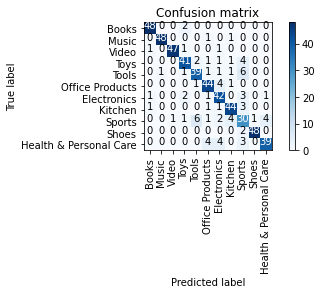

In [29]:
# compute the confusion matrix
confusion_mtx_distilbert = confusion_matrix(distilbert_labels, distilbert_preds)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx_distilbert,
            classes = classes)

In [32]:
# find false positive
false_positive_reviews_distilbert = []
for i in range(550):
    id = distilbert_res_corr[i]['Id']
    if distilbert_res_corr[i]['pred'] == 'Sports' and df.query(f'Id == {id}')['product_category'].item() == 'Tools':
        false_positive_reviews_distilbert.append(df.query(f'Id == {id}')['review_body'].item())
        
false_positive_reviews_distilbert

KeyError: 0

### fewshot fine-tuning on electra

In [38]:
# create embedding
tokenizer = AutoTokenizer.from_pretrained("google/electra-base-discriminator")
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, add_special_tokens=True, max_length=512)
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/1650 [00:00<?, ? examples/s]

Map:   0%|          | 0/550 [00:00<?, ? examples/s]

In [39]:
# create model
model = AutoModelForSequenceClassification.from_pretrained(
   "google/electra-base-discriminator", num_labels=11, id2label=id2label, label2id=label2id
)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
training_args = TrainingArguments(
    output_dir="amazon_product_corr_models_electra",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps = 10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/li.yunke/.local/lib/python3.9/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the 

Epoch,Training Loss,Validation Loss,Accuracy
1,1.338800,1.166540,0.723636
2,0.699800,0.651918,0.825455
3,0.391200,0.570397,0.847273
4,0.268900,0.577920,0.856364
5,0.144200,0.570477,0.861818


TrainOutput(global_step=520, training_loss=0.7328795162531045, metrics={'train_runtime': 185.8574, 'train_samples_per_second': 44.389, 'train_steps_per_second': 2.798, 'total_flos': 1684672793813508.0, 'train_loss': 0.7328795162531045, 'epoch': 5.0})

### evaluation on electra

In [35]:
# load pretrained model
tokenizer_electra = AutoTokenizer.from_pretrained("google/electra-base-discriminator")
model_electra = AutoModelForSequenceClassification.from_pretrained(
    "amazon_product_corr_models_electra/checkpoint-520", num_labels=11, id2label=id2label, label2id=label2id
)

In [36]:
device = torch.device('cuda')
model_electra = model_electra.to(device)

In [37]:
model_electra.device

device(type='cuda', index=0)

In [68]:
if not os.path.exists("./electra_eval_results_task2.json"):
    electra_out = pipeline_corr_eval_slm(tokenizer_electra, model_electra, test_dataset, id2label)
    with open("./electra_eval_results_task2.json", "w") as f:
        json.dump(electra_out,f)
    print('=> save results to electra_eval_results_task2.json')
else:
    with open("./electra_eval_results_task2.json", "r") as f:
        data = json.load(f)
        electra_res_corr = data['res_corr']
        electra_correct_corr = data['correct_corr']
        electra_correct_corr_top2 = data['correct_corr_top2']
        electra_correct_corr_top3 = data['correct_corr_top3']
        electra_total_corr = data['total_corr']
        electra_runtime_corr = data['runtime_corr']
        electra_preds = data['preds']
        electra_labels = data['labels']
        electra_incorrect = data['incorrect']
        electra_fp = data['fp']
        electra_fn = data['fn']
        print('=> load results from electra_eval_results_task2.json')


=> load results from electra_eval_results_task2.json


In [38]:
# calculate MAP
if not os.path.exists("./electra_eval_results_task2_map.json"):
    electra_out_map = pipeline_corr_eval_slm_map(tokenizer_electra, model_electra, test_dataset, id2label)
    with open("./electra_eval_results_task2_map.json", "w") as f:
        json.dump(electra_out_map,f)
    print('=> save results to electra_eval_results_task2_map.json')
else:
    with open("./electra_eval_results_task2_map.json", "r") as f:
        electra_out_map = json.load(f)
    print('=> load results from distilbert_eval_results_task2_map.json')
print(f'ELECTRA MAP:', electra_out_map['MAP'])

  0%|          | 0/550 [00:00<?, ?it/s]

(550, 11)
=> save results to electra_eval_results_task2_map.json
ELECTRA MAP: 0.8688483558871334


In [45]:
import numpy as np

correct_corr = electra_out['correct_corr']  
fp = electra_out['fp']  
fn = electra_out['fn'] 

precision_per_class = {}
recall_per_class = {}

for category in range(11): 
    TP = correct_corr[category]
    FP = fp[category]
    FN = fn[category]
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN) 
    
    precision_per_class[category] = precision
    recall_per_class[category] = recall

for category in range(11):
    print(f"Category {category} - Precision: {precision_per_class[category]:.2f}, Recall: {recall_per_class[category]:.2f}")


Category 0 - Precision: 0.92, Recall: 0.96
Category 1 - Precision: 1.00, Recall: 0.94
Category 2 - Precision: 0.98, Recall: 0.96
Category 3 - Precision: 0.87, Recall: 0.82
Category 4 - Precision: 0.80, Recall: 0.80
Category 5 - Precision: 0.88, Recall: 0.84
Category 6 - Precision: 0.79, Recall: 0.76
Category 7 - Precision: 0.90, Recall: 0.92
Category 8 - Precision: 0.62, Recall: 0.68
Category 9 - Precision: 0.94, Recall: 0.96
Category 10 - Precision: 0.81, Recall: 0.84


In [69]:
# calculate the top-1 accuracy
for key,val in id2label.items():
    print(f'==> {val} Accuracy: {electra_correct_corr[int(key)]/electra_total_corr[int(key)]}')
print(f'==> Total Accuracy: {np.sum(electra_correct_corr) / np.sum(electra_total_corr)}')
print(f'==> Total Runtime: {electra_runtime_corr}')

==> Books Accuracy: 0.96
==> Music Accuracy: 0.94
==> Video Accuracy: 0.96
==> Toys Accuracy: 0.82
==> Tools Accuracy: 0.8
==> Office Products Accuracy: 0.84
==> Electronics Accuracy: 0.76
==> Kitchen Accuracy: 0.92
==> Sports Accuracy: 0.68
==> Shoes Accuracy: 0.96
==> Health & Personal Care Accuracy: 0.84
==> Total Accuracy: 0.8618181818181818
==> Total Runtime: 44.143393993377686


In [28]:
# calculate the top-2 accuracy
for key,val in id2label.items():
    print(f'==> {val} Accuracy: {electra_correct_corr_top2[int(key)]/electra_total_corr[int(key)]}')
print(f'==> Total Accuracy: {np.sum(electra_correct_corr_top2) / np.sum(electra_total_corr)}')
print(f'==> Total Runtime: {electra_runtime_corr}')

==> Books Accuracy: 0.92
==> Music Accuracy: 0.92
==> Video Accuracy: 0.96
==> Toys Accuracy: 0.94
==> Tools Accuracy: 0.8
==> Office Products Accuracy: 0.94
==> Electronics Accuracy: 0.92
==> Kitchen Accuracy: 0.92
==> Sports Accuracy: 0.86
==> Shoes Accuracy: 0.9
==> Health & Personal Care Accuracy: 0.92
==> Total Accuracy: 0.9090909090909091
==> Total Runtime: 33.52217411994934


In [29]:
# calculate the top-3 accuracy
for key,val in id2label.items():
    print(f'==> {val} Accuracy: {electra_correct_corr_top3[int(key)]/electra_total_corr[int(key)]}')
print(f'==> Total Accuracy: {np.sum(electra_correct_corr_top3) / np.sum(electra_total_corr)}')
print(f'==> Total Runtime: {electra_runtime_corr}')

==> Books Accuracy: 1.0
==> Music Accuracy: 0.96
==> Video Accuracy: 0.96
==> Toys Accuracy: 0.96
==> Tools Accuracy: 0.84
==> Office Products Accuracy: 0.94
==> Electronics Accuracy: 0.96
==> Kitchen Accuracy: 0.94
==> Sports Accuracy: 0.88
==> Shoes Accuracy: 0.9
==> Health & Personal Care Accuracy: 0.94
==> Total Accuracy: 0.9345454545454546
==> Total Runtime: 33.52217411994934


|Model|top-1 acc|top-2 acc|top-3 acc|
|-|-|-|-|
|distilBERT|0.842|0.907|0.944|
|ELECTRA|0.847|0.909|0.934|

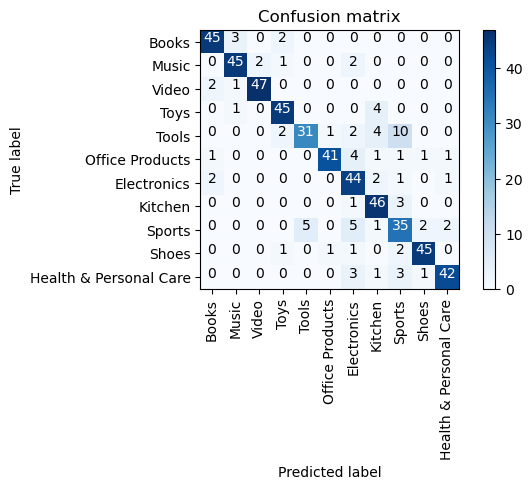

In [91]:
# compute the confusion matrix for best LR model
confusion_mtx_electra = confusion_matrix(electra_labels, electra_preds)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx_electra,
            classes = classes)

In [75]:
# find false positive
false_positive_reviews_electra = []
for i in range(550):
    id = electra_res_corr[i]['Id']
    if electra_res_corr[i]['pred'] == 'Sports' and df.query(f'Id == {id}')['product_category'].item() == 'Tools':
        false_positive_reviews_electra.append(df.query(f'Id == {id}')['review_body'].item())
        
false_positive_reviews_electra

["Big beefy knife, thick blade! Takes an edge well, haven't used it enough to see if it will hold up.",
 'A new direction in knife making.....a knife that gives the common man, trust, confidence,  value, quality and does what Shrade says it will do.........if you can find a better knife for the money....buy it!......Thank you Schrade',
 "Probably the best knife for the money! The quality of the knife if not the same, exceeds better than any high price knife! From the 1/4 inch high carbon steel thick blade that's runs from tip all the way to the back of handle, style, and shape you'll be amaze! Anyone who purchase this knife will not be disappointed! I love this knife!! This Extreme survival knife is extremely recommend it!! .. See any YouTube videos for it's performance!",
 "it comes well packaged in a quality box.its larger than i expected.it comes extremely sharp.its not what id call elegant but more like a body builder on steroids!! to be fair its the first survival fixed blade i ha

## LLM correlation analysis

### define LLM correlation anaylsis pipeline

In [46]:
import torch
import torch.nn.functional as F

def pipeline_corr_eval_llm(pipe, data, template, label2id):
    res_dict = {}
    correct = [0 for _ in range(11)]
    correct_top2 = [0 for _ in range(11)]
    correct_top3 = [0 for _ in range(11)]
    
    total = [0 for _ in range(11)]
    preds = []
    labels = []
    
    incorrect = []
    fp = [0 for _ in range(11)]
    fn = [0 for _ in range(11)]

    start_time = time.time()
    for i, row in tqdm(enumerate(data), total=len(data)):
        text = row['text']
        label = int(row['label'])
        prompt = template.format(text = text)
        result = pipe(prompt)[0]

        # Extracting prediction types from generated_text
        pred_types_raw = result['generated_text']
    
        # Keep only the part after ':' for each prediction type and join them
        pred_types_joined = ', '.join([pt.split(':', 1)[1].strip() if ':' in pt else pt for pt in pred_types_raw.split(', ')])

        # Now split the joined string by ','
        pred_types = pred_types_joined.split(', ')

        pred_ids = []
        
        # get rid of pred_type which is not in the label_space
        for pt in pred_types:
            try:
                pred_id = int(label2id[pt])
                pred_ids.append(pred_id)
            except KeyError:
                pred_ids.append(99)

        
        result['Id'] = row['Id']
        
        res_dict[i] = {'Id': row['Id'], 'pred':result['generated_text']}
        
        preds.append(pred_ids)
        labels.append(label)
        
        total[label] += 1
        # Check for correct predictions
        # Check for correct top 1 prediction
        if pred_ids and label == pred_ids[0]:
            correct[label] += 1

        # Check for correct top 2 predictions
        if len(pred_ids) > 1 and label in pred_ids[:2]:
            correct_top2[label] += 1

        # Check for correct top 3 predictions
        if len(pred_ids) > 2 and label in pred_ids[:3]:
            correct_top3[label] += 1
        
        if label not in pred_ids[:3]:
            d = {"pred": [id2label[pred] for pred in list(pred_cls_top3)], 
                   "label": label, "review": text, "probability": str(probs)}
            incorrect.append(d)
            fp[pred_cls] += 1
            fn[label] += 1
    
    end_time = time.time()
    runtime = end_time - start_time
    
    out_dict = {}
    out_dict['res_corr'] = res_dict
    out_dict['correct_corr'] = correct
    out_dict['correct_corr_top2'] = correct_top2
    out_dict['correct_corr_top3'] = correct_top3
    out_dict['total_corr'] = total
    out_dict['runtime_corr'] = runtime
    out_dict['preds'] = preds
    out_dict['labels'] = labels
    out_dict['incorrect'] = incorrect
    out_dict['fp'] = fp
    out_dict['fn'] = fn
    # return res_dict, correct, correct_top2, correct_top3, total, runtime, preds, labels, incorrect
    return out_dict



    start_time = time.time()
    model = model.to('cuda:0')
    with torch.no_grad():
        for i, row in tqdm(enumerate(data), total=len(data)):
          text = row['text']
          label = int(row['label'])
          token = tokenizer(text, truncation=True, add_special_tokens=True, max_length=512, padding=True, return_tensors="pt").to('cuda:0')
          logits = model(**token).logits
          pred_cls = logits.argmax(axis=1).cpu().item()
          pred_cls_top3 = logits.argsort(axis=1)[0][-3:].cpu().numpy()
          # pred_logits = logits.sort(axis=1)[0][-3:].cpu().numpy()
          
          probs = F.softmax(logits, dim=1).sort(axis=1).values[0][-3:].cpu().numpy().sum() 
          
          res_dict[i] = {'Id': row['Id'], 'pred': id2label[pred_cls]}
          total[label] += 1
          preds.append(pred_cls)
          labels.append(label)
          if pred_cls == label:
              correct[int(label)] += 1
              correct_top2[int(label)] += 1
              correct_top3[int(label)] += 1
          elif label == pred_cls_top3[1]:
              correct_top2[int(label)] += 1
              correct_top3[int(label)] += 1
          elif label == pred_cls_top3[0]:
              correct_top3[int(label)] += 1
          else:
              d = {"pred": [id2label[pred] for pred in list(pred_cls_top3)], 
                   "label": label, "review": text, "probability": str(probs)}
              incorrect.append(d)
            
          if pred_cls != label:
            fp[pred_cls] += 1
            fn[label] += 1


    end_time = time.time()
    runtime = end_time - start_time
    out_dict = {}
    out_dict['res_corr'] = res_dict
    out_dict['correct_corr'] = correct
    out_dict['correct_corr_top2'] = correct_top2
    out_dict['correct_corr_top3'] = correct_top3
    out_dict['total_corr'] = total
    out_dict['runtime_corr'] = runtime
    out_dict['preds'] = preds
    out_dict['labels'] = labels
    out_dict['incorrect'] = incorrect
    out_dict['fp'] = fp
    out_dict['fn'] = fn

    return out_dict

### zero-shot inference on FLAN-T5

In [11]:
task_name = 'text classification'
label_space = ["Books", "Music", "Video", "Toys", "Tools", "Office Products", "Electronics", "Kitchen", "Sports", "Shoes", "Health & Personal Care"]
task_definition = f'Given the sentence, assign a product label from {label_space}'
output_format = "Return label only without any other text."

template = f"Please perform {task_name} task.\n{task_definition}\n{output_format}\nSentence:\n" + "{text}."

In [ ]:
task_name = 'text classification'
label_space = ["Books", "Music", "Video", "Toys", "Tools", "Office Products", "Electronics", "Kitchen", "Sports", "Shoes", "Health & Personal Care"]
task_definition = f'Given the sentence, assign three most correlated product labels from {label_space}'
output_format = "Return labels only without any other text."

template = f"Please perform {task_name} task.\n{task_definition}\n{output_format}\nSentence:\n" + "{text}."

In [55]:
# Flan-T5
pipeFlanT5 = pipeline("text2text-generation", model="google/flan-t5-xxl", device=0)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [57]:
example = test_dataset[100]['text']
start_time = time.time()
prompt = template.format(text = example)
output = pipeFlanT5(prompt)
end_time = time.time()
print(f'input : {example}')
print(f'output : {output}')
print(f'runtime : {end_time-start_time}')

/home/xiao.yang3/.conda/envs/llama2/lib/python3.11/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


input : The Film Follows The Adventures of Anastasia, a Rusin Princess Who Lost Her Memery Years Ago As A Young Girl. On Her Way To Paris To See Her Gandma, She Bumps Into Demetrie and Vlad Who Help On Her Journey. Meanwhile, Evil Velian Russputain and Sidekick Bartok The Bat Try To Distroy Anastasia From Knowing Who She Was Years Ago.    ANASTASIA is Not Anwhere Near Don Bluth's Best Film Made, But This is Still One of The Best Animated Films Made.    The Animation Even Being 2D Animation, is Absolutly Realistic.    The Voice Talents Are Great Featuring Meg Ryan as Anastasia, John Cussack (From MARTIAN CHILD) as Demitrie, Christopher Lloyd (From BACK TO THE FUTURE) as Rusputian, Hank Arazaria (From THE SIMPSONS) as The Sidekick Bartok, Among Others.    The Directors Don Bluth (THE SECRET OF NIMH) and Gary Goldman (TITAN A.E.) Have Made A Great Film Though It's Not for the Whole Family (Violene and Suspence), Thay've Made One Great Film That Will Be Timeless For Generations To Come.   

In [25]:
if not os.path.exists("./FlanT5_eval_results_task2.json"):
    FlanT5_res_corr, FlanT5_correct_corr, FlanT5_total_corr, FlanT5_runtime_corr, FlanT5_preds, FlanT5_labels = pipeline_corr_eval_llm(pipeFlanT5, test_dataset, template, label2id)
    with open("./FlanT5_eval_results_task2.json", "w") as f:
        data = {}
        data['res_corr'] = FlanT5_res_corr
        data['correct_corr'] = FlanT5_correct_corr
        data['total_corr'] = FlanT5_total_corr
        data['runtime_corr'] = FlanT5_runtime_corr
        data['preds'] = FlanT5_preds
        data['labels'] = FlanT5_labels
        json.dump(data,f)
    print('=> save results to FlanT5_eval_results_task2.json')
else:
    with open("./FlanT5_eval_results_task2.json", "r") as f:
        data = json.load(f)
        FlanT5_res_corr = data['res_corr']
        FlanT5_correct_corr = data['correct_corr']
        FlanT5_total_corr = data['total_corr']
        FlanT5_runtime_corr = data['runtime_corr']
        FlanT5_preds = data['preds']
        FlanT5_labels = data['labels']
    print('=> load results from FlanT5_eval_results_task2.json')

=> load results from FlanT5_eval_results_task2.json


In [26]:
# calculate the accuracy
for key,val in id2label.items():
    print(f'==> {val} Accuracy: {FlanT5_correct_corr[int(key)]/FlanT5_total_corr[int(key)]}')
print(f'==> Total Accuracy: {np.sum(FlanT5_correct_corr) / np.sum(FlanT5_total_corr)}')
print(f'==> Total Runtime: {FlanT5_runtime_corr}')

==> Books Accuracy: 0.94
==> Music Accuracy: 0.96
==> Video Accuracy: 0.98
==> Toys Accuracy: 1.0
==> Tools Accuracy: 0.86
==> Office Products Accuracy: 0.3
==> Electronics Accuracy: 0.94
==> Kitchen Accuracy: 0.58
==> Sports Accuracy: 0.12
==> Shoes Accuracy: 0.94
==> Health & Personal Care Accuracy: 0.38
==> Total Accuracy: 0.7272727272727273
==> Total Runtime: 176.13426733016968


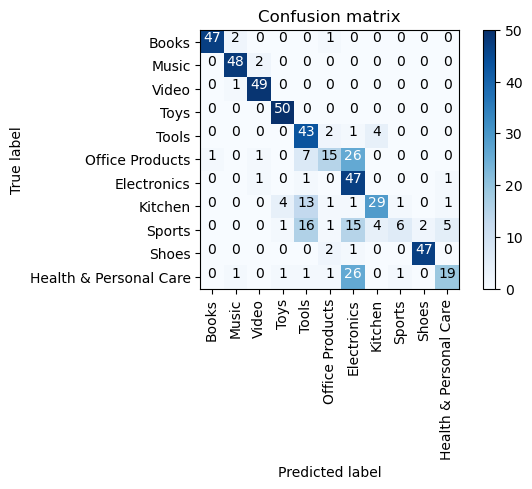

In [64]:
# compute the confusion matrix for best LR model
confusion_mtx_FlanT5 = confusion_matrix(FlanT5_labels, FlanT5_preds)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx_FlanT5,
            classes = classes)

In [29]:
# find false positive
false_positive_reviews_FlanT5 = []
for i in range(550):
    id = FlanT5_res_corr[str(i)]['Id']
    if FlanT5_res_corr[str(i)]['pred'] == 'Tools' and df.query(f'Id == {id}')['product_category'].item() == 'Sports':
        false_positive_reviews_FlanT5.append(df.query(f'Id == {id}')['review_body'].item())
        
false_positive_reviews_FlanT5

['american made what else is needed nice hefty blade and shave the hair off your arm straight out of the box great knife for a great price the scabered that it comes with takes  some power to get it out but thats what you want when moving around wont accidently fall or get pulled out. this knife is made to work and will last a life time',
 "WOW, That was the first word out of my mouth when I held this knife. Everything about this knife is perfect the weight,the size,the thickness (it's thickier then a pry bar)and it's durability. Your just not going to break this knife. I love it!",
 'i just recieved my knife this morning and its incredibly sharp, I litterally shaved with it. i was slightly disapointed when i tested its tip and stabbed a 2x4.the tip dulled dramatically from what it had been, but its not bad and im still very impressed. when this weekend comes around itl be time to start testing it.<br /><br />Thank you for all your reviews everyone, you all helped me make my decision i

### zero-shot inference on FLAN-UL2

In [9]:
# flan-UL2
pipeFlanUL2 = pipeline("text2text-generation", model="google/flan-ul2", device=0)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [12]:
example = test_dataset[100]['text']
start_time = time.time()
prompt = template.format(text = example)
output = pipeFlanUL2(prompt)
end_time = time.time()
print(f'input : {example}')
print(f'output : {output}')
print(f'runtime : {end_time-start_time}')

/home/xiao.yang3/.conda/envs/llama2/lib/python3.11/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


input : The Film Follows The Adventures of Anastasia, a Rusin Princess Who Lost Her Memery Years Ago As A Young Girl. On Her Way To Paris To See Her Gandma, She Bumps Into Demetrie and Vlad Who Help On Her Journey. Meanwhile, Evil Velian Russputain and Sidekick Bartok The Bat Try To Distroy Anastasia From Knowing Who She Was Years Ago.    ANASTASIA is Not Anwhere Near Don Bluth's Best Film Made, But This is Still One of The Best Animated Films Made.    The Animation Even Being 2D Animation, is Absolutly Realistic.    The Voice Talents Are Great Featuring Meg Ryan as Anastasia, John Cussack (From MARTIAN CHILD) as Demitrie, Christopher Lloyd (From BACK TO THE FUTURE) as Rusputian, Hank Arazaria (From THE SIMPSONS) as The Sidekick Bartok, Among Others.    The Directors Don Bluth (THE SECRET OF NIMH) and Gary Goldman (TITAN A.E.) Have Made A Great Film Though It's Not for the Whole Family (Violene and Suspence), Thay've Made One Great Film That Will Be Timeless For Generations To Come.   

In [16]:
if not os.path.exists("./FlanUL2_eval_results_task2.json"): 
    FlanUL2_res_corr, FlanUL2_correct_corr, FlanUL2_total_corr, FlanUL2_runtime_corr, FlanUL2_preds, FlanUL2_labels = pipeline_corr_eval_llm(pipeFlanUL2, test_dataset, template, label2id)
    with open("./FlanUL2_eval_results_task2.json", "w") as f:
        data = {}
        data['res_corr'] = FlanUL2_res_corr
        data['correct_corr'] = FlanUL2_correct_corr
        data['total_corr'] = FlanUL2_total_corr
        data['runtime_corr'] = FlanUL2_runtime_corr
        data['preds'] = FlanUL2_preds
        data['labels'] = FlanUL2_labels
        json.dump(data,f)
    print('=> save results to FlanUL2_eval_results_task2.json')
else:
    with open("./FlanUL2_eval_results_task2.json", "r") as f:
        data = json.load(f)
        FlanUL2_res_corr = data['res_corr']
        FlanUL2_correct_corr = data['correct_corr']
        FlanUL2_total_corr = data['total_corr']
        FlanUL2_runtime_corr = data['runtime_corr']
        FlanUL2_preds = data['preds']
        FlanUL2_labels = data['labels']
    print('=> load results from FlanUL2_eval_results_task2.json')

NameError: name 'os' is not defined

In [19]:
# calculate the accuracy
for key,val in id2label.items():
    print(f'==> {val} Accuracy: {FlanUL2_correct_corr[int(key)]/FlanUL2_total_corr[int(key)]}')
print(f'==> Total Accuracy: {np.sum(FlanUL2_correct_corr) / np.sum(FlanUL2_total_corr)}')
print(f'==> Total Runtime: {FlanUL2_runtime_corr}')

==> Books Accuracy: 0.96
==> Music Accuracy: 1.0
==> Video Accuracy: 0.98
==> Toys Accuracy: 0.98
==> Tools Accuracy: 0.8
==> Office Products Accuracy: 0.5
==> Electronics Accuracy: 0.96
==> Kitchen Accuracy: 0.6
==> Sports Accuracy: 0.2
==> Shoes Accuracy: 0.96
==> Health & Personal Care Accuracy: 0.48
==> Total Accuracy: 0.7654545454545455
==> Total Runtime: 268.7550759315491


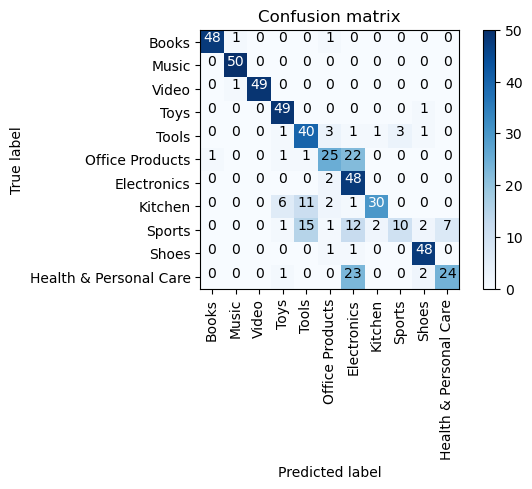

In [20]:
# compute the confusion matrix for best LR model
confusion_mtx_FlanUL2 = confusion_matrix(FlanUL2_labels, FlanUL2_preds)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx_FlanUL2,
            classes = classes)

In [21]:
# find false positive
false_positive_reviews_FlanUL2 = []
for i in range(550):
    id = FlanUL2_res_corr[i]['Id']
    if FlanUL2_res_corr[i]['pred'] == 'Electronics' and df.query(f'Id == {id}')['product_category'].item() == 'Health & Personal Care':
        false_positive_reviews_FlanUL2.append(df.query(f'Id == {id}')['review_body'].item())
        
false_positive_reviews_FlanUL2

['This item was purchased by me in an effort to see if these types of hearing devices could help.  This one worked very well, but was designed to listen to birds and bird watching.  I returned the item, not because it was defective, but to purchase one made for special hearing aids.',
 "I worked and worked and worked to try and get it to focus on my TV but was never successful. At standard viewing distance you can only see part of the screen and even that is not comfortable viewing. What a waste of money! You would think a German product would have better engineering than this. I hardly return anything but I'm going to try and get my money back on this one.<br /><br />Rick<br /><br />Edit 9/1/13: The product did not work for me but I am PLEASED with the seller. The refund process was simple and I received my refund promptly.<br /><br />Rick",
 "Connectivity not as clean as I expected.  I was looking for a device to connect to Microsoft HealthVault, so far I've been unable to connect. T